<a href="https://colab.research.google.com/github/Samjacob007/Advanced-Brain-Tumor-Diagnosis-with-CNNs-A-Multi-Task-Learning-Approach-for-MRI-Image-Classificatio/blob/main/brain_tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Importing necessary libraries and modules
import os
import random
import io
import datetime
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    BatchNormalization,
    LeakyReLU,
)
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

# OpenCV
import cv2

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle, class_weight, compute_class_weight
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
)
from imblearn.over_sampling import SMOTE

# Google Colab
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the project path without spaces in the mount point
base_path = '/content/drive/MyDrive/project/brain tumor'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:


# Labels and image size
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
image_size = 224  # Resize all images to 224x224
sample_size = 500  # Number of samples per class

# Initialize empty lists for data
x_train = []
y_train_classification = []
x_test = []
y_test_classification = []

base_path = '/content/drive/MyDrive/project/brain tumor'

# Function to load and sample random images
def load_and_sample_images(base_path, subset, sample_size):
    data, labels_list = [], []
    for label_idx, label in enumerate(labels):
        subset_path = os.path.join(base_path, subset, label)
        all_files = os.listdir(subset_path)
        sampled_files = random.sample(all_files, min(len(all_files), sample_size))  # Randomly sample
        for file in tqdm(sampled_files, desc=f"Processing {subset} - {label}"):
            image = cv2.imread(os.path.join(subset_path, file))
            image = cv2.resize(image, (image_size, image_size))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
            data.append(image)
            labels_list.append(label_idx)
    return np.array(data), np.array(labels_list)

# Load training data
x_train, y_train_classification = load_and_sample_images(base_path, 'Training', sample_size)

# Load testing data
x_test, y_test_classification = load_and_sample_images(base_path, 'Testing', sample_size)

# Normalize pixel values
x_train = x_train / 255.0
x_test = x_test / 255.0

# One-hot encode labels
y_train_classification = to_categorical(y_train_classification, num_classes=len(labels))
y_test_classification = to_categorical(y_test_classification, num_classes=len(labels))

# Verify data shapes
print(f"x_train shape: {x_train.shape}")
print(f"y_train_classification shape: {y_train_classification.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test_classification shape: {y_test_classification.shape}")

# Verify class distribution
print("Training class distribution:", Counter(np.argmax(y_train_classification, axis=1)))
print("Testing class distribution:", Counter(np.argmax(y_test_classification, axis=1)))

Processing Testing - pituitary: 100%|██████████| 300/300 [00:03<00:00, 75.67it/s] 


x_train shape: (2000, 224, 224, 3)
y_train_classification shape: (2000, 4)
x_test shape: (1311, 224, 224, 3)
y_test_classification shape: (1311, 4)
Training class distribution: Counter({0: 500, 1: 500, 2: 500, 3: 500})
Testing class distribution: Counter({2: 405, 1: 306, 0: 300, 3: 300})


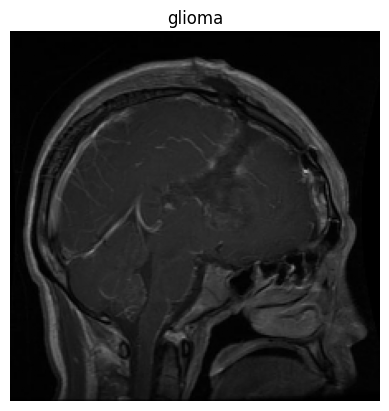

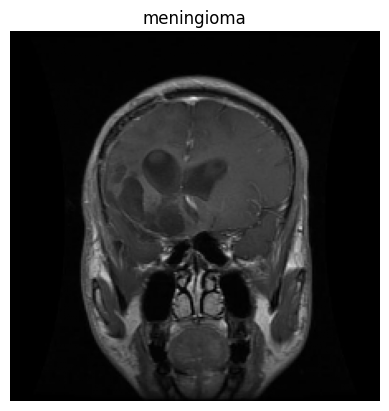

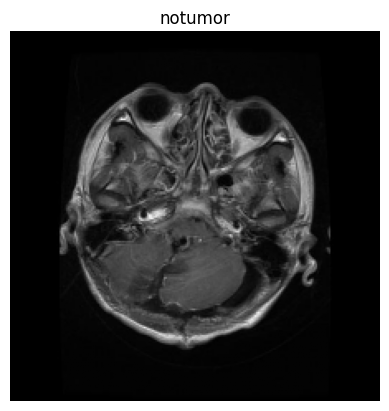

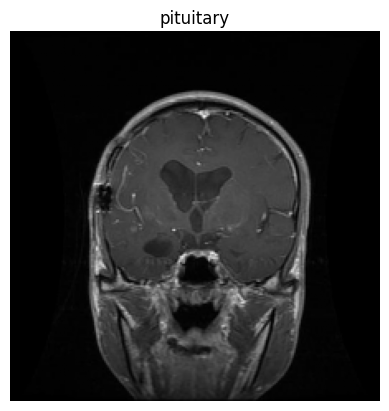

In [4]:

# Display the first image for each class
for i in range(4):
    plt.imshow(x_train[i])  # Assuming your data is ordered by class
    plt.title(labels[i])  # Display class name
    plt.axis('off')
    plt.show()

In [5]:

# Shuffle data and labels
x_train, y_train_classification = shuffle(x_train, y_train_classification, random_state=42)

In [6]:


# Split the training data into training and validation sets
x_train_final, x_val, y_train_final, y_val = train_test_split(
    x_train, y_train_classification, test_size=0.2, random_state=42
)

# Check the shapes of the splits
print(f"x_train_final shape: {x_train_final.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_train_final shape: {y_train_final.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test_classification shape: {y_test_classification.shape}")


x_train_final shape: (1600, 224, 224, 3)
x_val shape: (400, 224, 224, 3)
x_test shape: (1311, 224, 224, 3)
y_train_final shape: (1600, 4)
y_val shape: (400, 4)
y_test_classification shape: (1311, 4)


In [7]:
# Function to count class distribution
def count_class_distribution(y_data):
    # If one-hot encoded, sum across axis 0 to count each class
    if len(y_data.shape) == 2 and y_data.shape[1] > 1:
        return np.sum(y_data, axis=0)
    # Otherwise, use bincount for single-label arrays
    return np.bincount(y_data)

# Check class distribution in each split
train_class_counts = count_class_distribution(y_train_final)
val_class_counts = count_class_distribution(y_val)
test_class_counts = count_class_distribution(y_test_classification)

# Print the class distribution
print("Training class distribution:", train_class_counts)
print("Validation class distribution:", val_class_counts)

Training class distribution: [394. 409. 393. 404.]
Validation class distribution: [106.  91. 107.  96.]


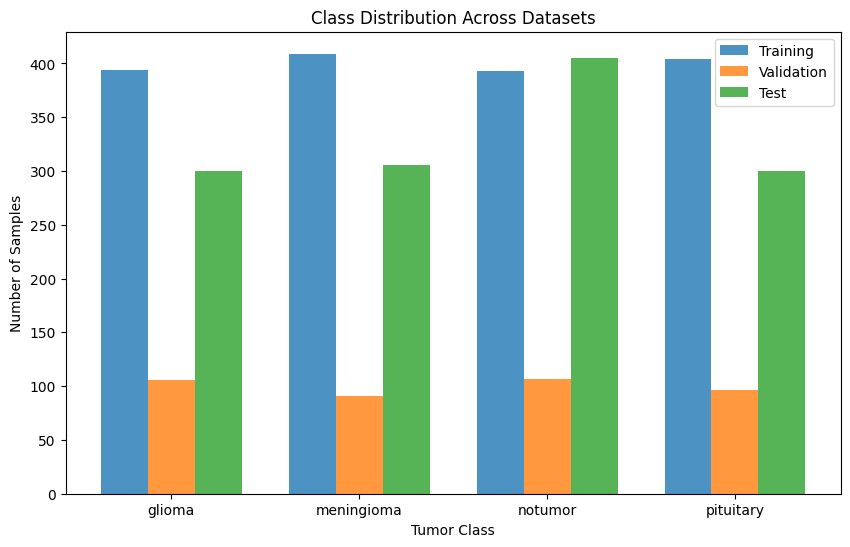

In [8]:

# Sum one-hot encoded labels to get class counts
train_class_counts = np.sum(y_train_final, axis=0)
val_class_counts = np.sum(y_val, axis=0)
test_class_counts = np.sum(y_test_classification, axis=0)

# Class names
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Plot bar chart
plt.figure(figsize=(10, 6))
bar_width = 0.25
x_indexes = np.arange(len(class_names))

plt.bar(x_indexes, train_class_counts, width=bar_width, label='Training', alpha=0.8)
plt.bar(x_indexes + bar_width, val_class_counts, width=bar_width, label='Validation', alpha=0.8)
plt.bar(x_indexes + 2 * bar_width, test_class_counts, width=bar_width, label='Test', alpha=0.8)

plt.xticks(x_indexes + bar_width, class_names)
plt.title("Class Distribution Across Datasets")
plt.xlabel("Tumor Class")
plt.ylabel("Number of Samples")
plt.legend()
plt.show()

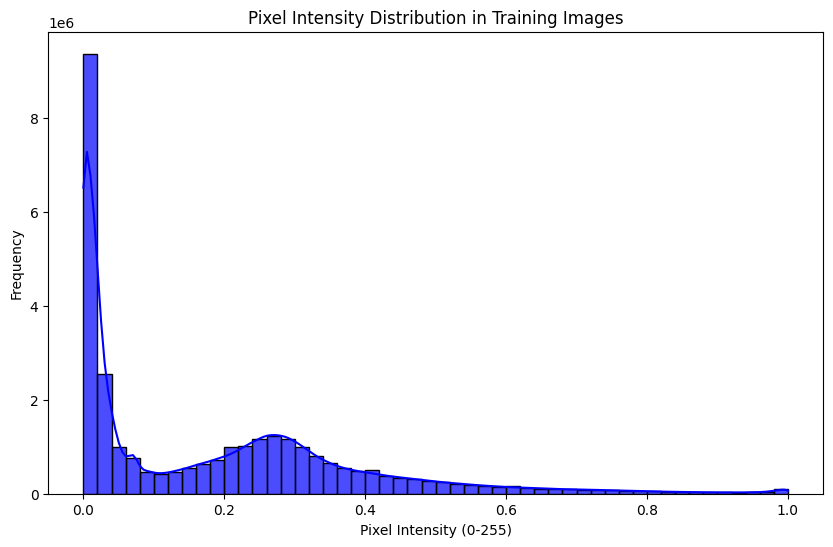

In [9]:


# Flatten pixel values of a random sample from the training set
random_sample = x_train_final[:200]  # Use 200 random images
flattened_pixels = random_sample.reshape(-1)

# Plot histogram of pixel intensities
plt.figure(figsize=(10, 6))
sns.histplot(flattened_pixels, bins=50, kde=True, color='blue', alpha=0.7)
plt.title("Pixel Intensity Distribution in Training Images")
plt.xlabel("Pixel Intensity (0-255)")
plt.ylabel("Frequency")
plt.show()


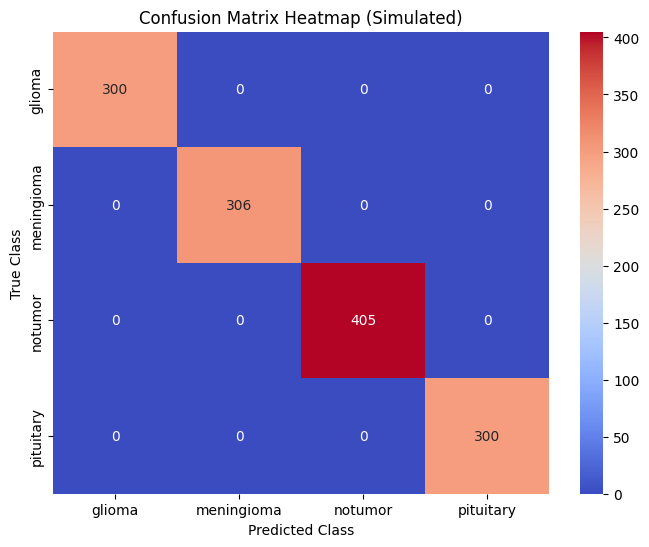

In [10]:

# Simulate predictions (replace with actual predictions if available)
y_pred_simulated = np.argmax(y_test_classification, axis=1)  # Simulated ground truth

# Compute confusion matrix
conf_matrix = confusion_matrix(np.argmax(y_test_classification, axis=1), y_pred_simulated)

# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix Heatmap (Simulated)")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

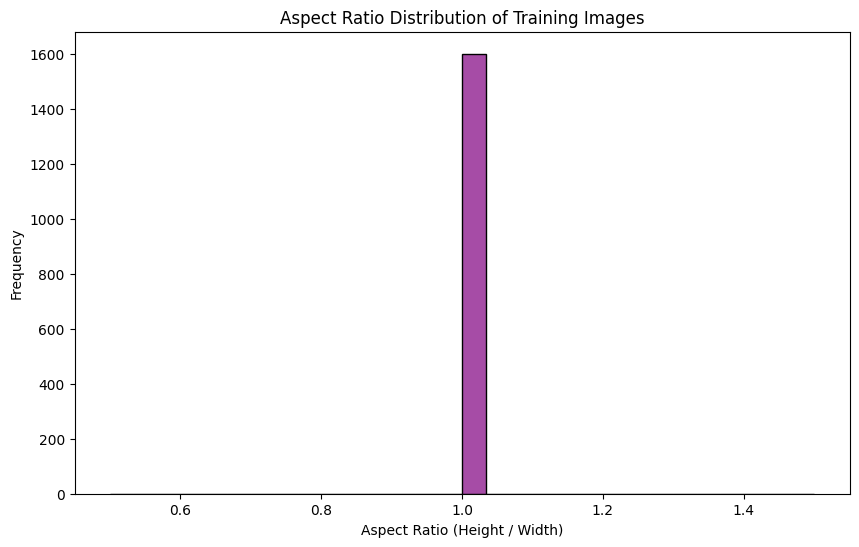

In [11]:
# Extract original image dimensions before resizing
heights = [img.shape[0] for img in x_train_final]
widths = [img.shape[1] for img in x_train_final]

# Calculate aspect ratios
aspect_ratios = np.array(heights) / np.array(widths)

# Plot histogram of aspect ratios
plt.figure(figsize=(10, 6))
sns.histplot(aspect_ratios, bins=30, kde=True, color='purple', alpha=0.7)
plt.title("Aspect Ratio Distribution of Training Images")
plt.xlabel("Aspect Ratio (Height / Width)")
plt.ylabel("Frequency")
plt.show()

In [12]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Apply data augmentation on the training set
datagen.fit(x_train_final)

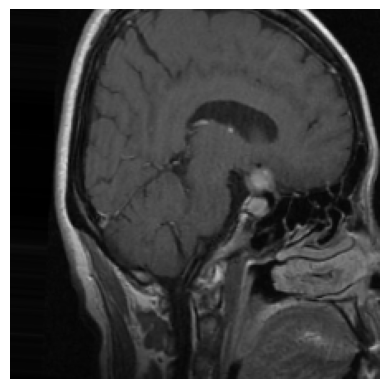

In [13]:
# Apply data augmentation on the training set
datagen.fit(x_train_final)

# Visualize Augmented Images
for x_batch, y_batch in datagen.flow(x_train_final, y_train_final, batch_size=4):
    for i in range(4):
        plt.imshow(x_batch[i])
        plt.axis('off')
    plt.show()
    break

In [14]:
# Load Pre-Trained VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Fine-Tune Last Few Layers
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Add Custom Layers
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)  # 4 classes: glioma, meningioma, notumor, pituitary

# Define Model
vgg_model = Model(inputs=base_model.input, outputs=output)

# Compile Model
vgg_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

58889256/58889256 [==============================] - 0s 0us/step


In [15]:
# Define Callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_vgg16_model.keras', monitor='val_loss', save_best_only=True)
]

In [16]:
# Train Model
history_vgg = vgg_model.fit(
    datagen.flow(x_train_final, y_train_final, batch_size=32),
    validation_data=(x_val, y_val),
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
50/50 [==============================] - 112s 2s/step - loss: 4.8912 - accuracy: 0.5375 - precision: 0.6601 - recall: 0.3969 - val_loss: 3.3929 - val_accuracy: 0.7825 - val_precision: 0.8084 - val_recall: 0.6750 - lr: 1.0000e-04
Epoch 2/30
50/50 [==============================] - 109s 2s/step - loss: 2.8624 - accuracy: 0.7775 - precision: 0.8085 - recall: 0.7281 - val_loss: 2.1912 - val_accuracy: 0.8650 - val_precision: 0.8817 - val_recall: 0.8575 - lr: 1.0000e-04
Epoch 3/30
50/50 [==============================] - 109s 2s/step - loss: 2.0849 - accuracy: 0.8213 - precision: 0.8418 - recall: 0.7781 - val_loss: 1.6547 - val_accuracy: 0.8850 - val_precision: 0.9005 - val_recall: 0.8600 - lr: 1.0000e-04
Epoch 4/30
50/50 [==============================] - 108s 2s/step - loss: 1.6569 - accuracy: 0.8431 - precision: 0.8749 - recall: 0.8087 - val_loss: 1.3720 - val_accuracy: 0.9050 - val_precision: 0.9255 - val_recall: 0.8700 - lr: 1.0000e-04
Epoch 5/30
50/50 [======================

In [17]:
# Evaluate Model
test_loss, test_accuracy, test_precision, test_recall = vgg_model.evaluate(x_test, y_test_classification, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")

41/41 [==============================] - 25s 600ms/step - loss: 0.3053 - accuracy: 0.9634 - precision: 0.9641 - recall: 0.9626
Test Loss: 0.30534839630126953
Test Accuracy: 0.9633867144584656
Test Precision: 0.9640947580337524
Test Recall: 0.9626239538192749


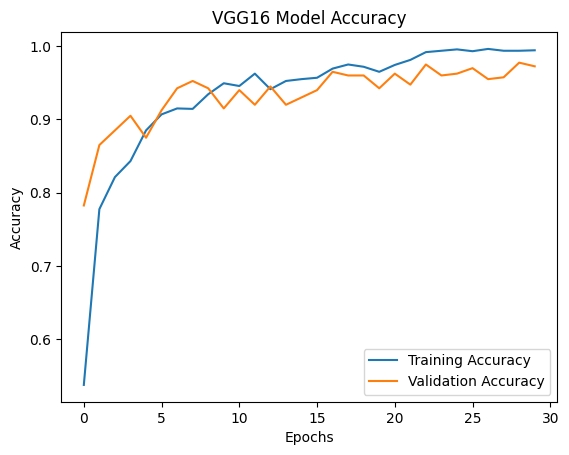

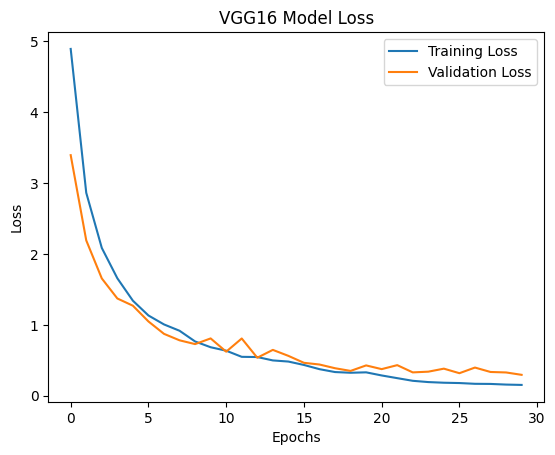

In [18]:
# Plot training and validation accuracy
plt.plot(history_vgg.history['accuracy'], label='Training Accuracy')
plt.plot(history_vgg.history['val_accuracy'], label='Validation Accuracy')
plt.title("VGG16 Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history_vgg.history['loss'], label='Training Loss')
plt.plot(history_vgg.history['val_loss'], label='Validation Loss')
plt.title("VGG16 Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

50/50 [==============================] - 30s 599ms/step


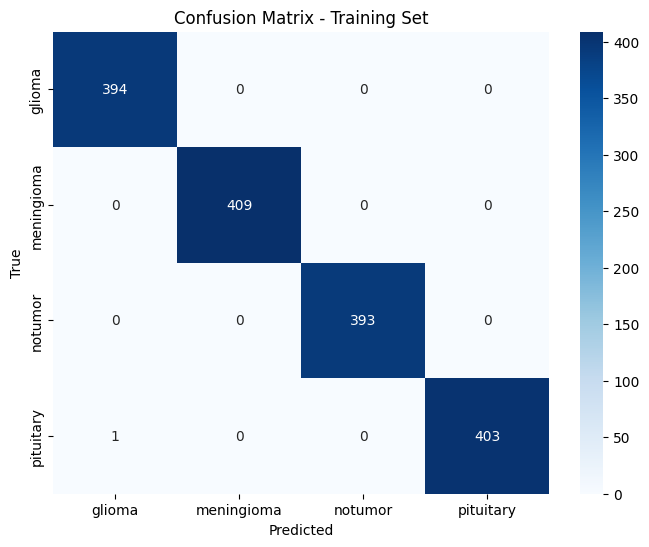

In [19]:
# Get predictions for the training set
y_pred_train = np.argmax(vgg_model.predict(x_train_final), axis=1)
y_true_train = np.argmax(y_train_final, axis=1)

# Generate the confusion matrix
cm_train = confusion_matrix(y_true_train, y_pred_train)

# Plot confusion matrix for the training set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Training Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

41/41 [==============================] - 25s 599ms/step

Classification Report:
               precision    recall  f1-score   support

      glioma       0.96      0.96      0.96       300
  meningioma       0.95      0.93      0.94       306
     notumor       0.98      0.97      0.98       405
   pituitary       0.96      0.99      0.98       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



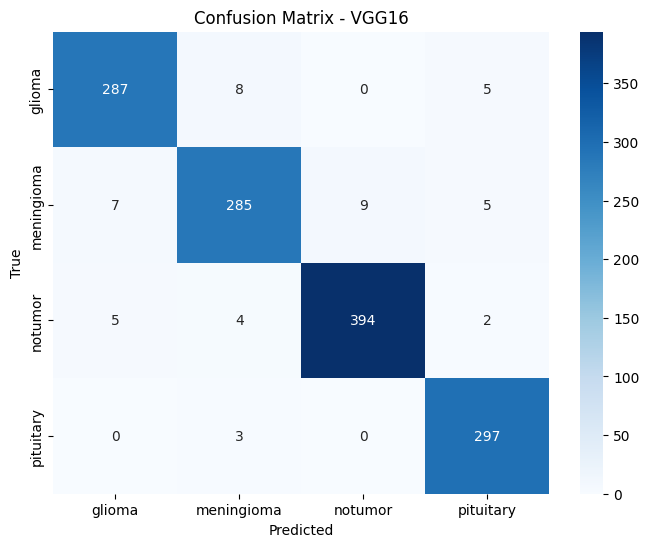

In [20]:
# Predictions
y_pred_vgg = np.argmax(vgg_model.predict(x_test), axis=1)
y_true = np.argmax(y_test_classification, axis=1)

# Classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred_vgg, target_names=labels))

# Confusion matrix
cm_vgg = confusion_matrix(y_true, y_pred_vgg)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_vgg, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - VGG16")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


41/41 [==============================] - 25s 607ms/step


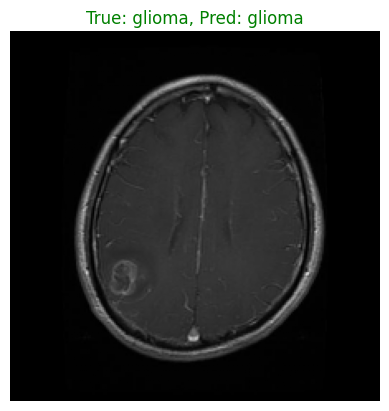

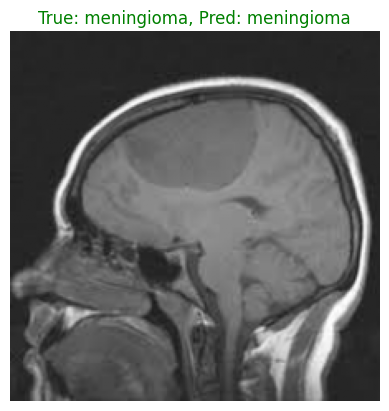

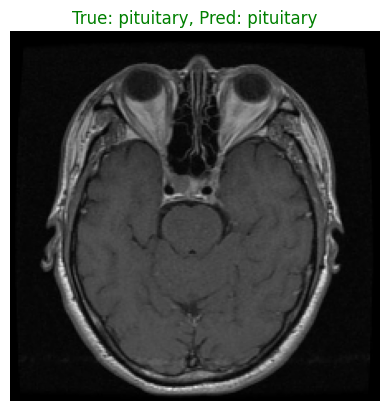

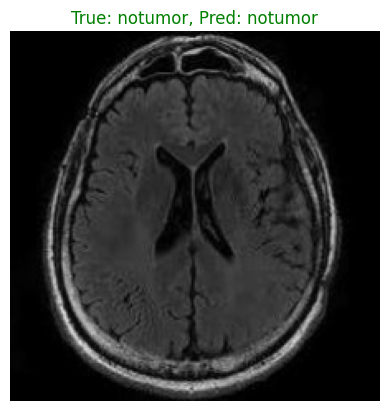

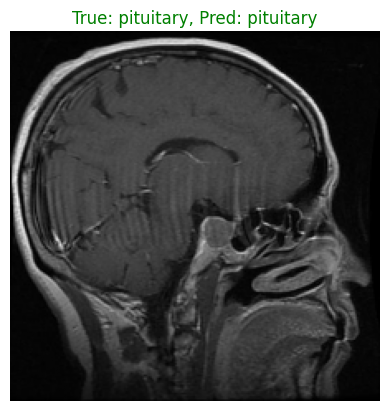

In [22]:
y_pred = np.argmax(vgg_model.predict(x_test), axis=1)  # Get class indices for predictions
for i in range(5):  # Display 5 random images
    idx = random.randint(0, len(x_test) - 1)  # Select a random index
    plt.imshow(x_test[idx])  # Display the corresponding image
    true_label = labels[np.argmax(y_test_classification[idx])]  # True label
    predicted_label = labels[y_pred[idx]]  # Predicted label
    color = 'green' if true_label == predicted_label else 'red'  # Highlight correct/incorrect
    plt.title(f"True: {true_label}, Pred: {predicted_label}", color=color)
    plt.axis('off')  # Hide axes
    plt.show()  # Display the image


In [23]:


# Define the dataset path and classes
base_path = '/content/drive/MyDrive/project/brain tumor'
class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
data_folders = ['Training', 'Testing']  # Choose whether to use Training or Testing images

# Function to fetch random images from each class
def fetch_images(base_path, data_folder, class_labels, num_samples=3):
    images_by_class = {}
    for label in class_labels:
        folder_path = os.path.join(base_path, data_folder, label)
        all_files = os.listdir(folder_path)
        sampled_files = random.sample(all_files, min(len(all_files), num_samples))  # Randomly sample
        images_by_class[label] = [os.path.join(folder_path, f) for f in sampled_files]
    return images_by_class

# Fetch images dynamically
sample_image_paths = fetch_images(base_path, 'Testing', class_labels)

# Print selected images for verification
for label, paths in sample_image_paths.items():
    print(f"Class: {label}")
    for path in paths:
        print(f"  {path}")

Class: glioma
  /content/drive/MyDrive/project/brain tumor/Testing/glioma/Te-gl_0158.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/glioma/Te-gl_0074.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/glioma/Te-gl_0137.jpg
Class: meningioma
  /content/drive/MyDrive/project/brain tumor/Testing/meningioma/Te-me_0268.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/meningioma/Te-me_0040.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/meningioma/Te-me_0249.jpg
Class: notumor
  /content/drive/MyDrive/project/brain tumor/Testing/notumor/Te-no_0100.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/notumor/Te-no_0255.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/notumor/Te-no_0173.jpg
Class: pituitary
  /content/drive/MyDrive/project/brain tumor/Testing/pituitary/Te-pi_0292.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/pituitary/Te-pi_0265.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/pituitary/Te-pi_0240.jpg


In [24]:


def visualize_gradcam(img_path, model, layer_name, class_labels):
    """
    Generate and display Grad-CAM heatmaps for an input image.
    """
    from tensorflow.keras.models import Model
    import tensorflow as tf

    # Load and preprocess the image
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize pixel values

    # Create a model that outputs the activations of the target layer
    grad_model = Model(
        inputs=[model.input],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    # Get the class index with the highest predicted probability
    preds = model.predict(img_array)
    pred_class_idx = np.argmax(preds[0])

    # Compute the gradient of the predicted class with respect to the activations
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, pred_class_idx]

    # Compute gradients
    grads = tape.gradient(loss, conv_outputs)
    guided_grads = grads[0]
    conv_outputs = conv_outputs[0]

    # Compute the Grad-CAM heatmap
    weights = np.mean(guided_grads, axis=(0, 1))
    heatmap = np.dot(conv_outputs, weights)

    # Normalize the heatmap between 0 and 1
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    # Resize heatmap to match the image size
    heatmap = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))

    # Convert heatmap to RGB format
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose heatmap onto the original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))  # Resize image to match Grad-CAM heatmap
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    # Display the image
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Grad-CAM - Predicted: {class_labels[pred_class_idx]}")
    plt.axis('off')
    plt.show()


Generating Grad-CAM for class: glioma

1/1 [==============================] - 0s 74ms/step


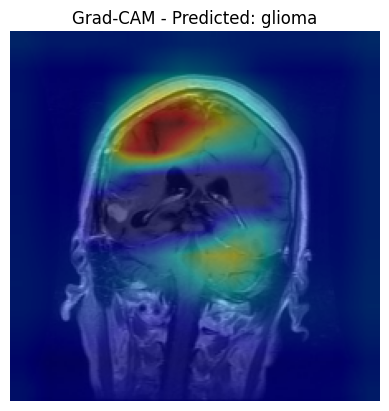

1/1 [==============================] - 0s 74ms/step


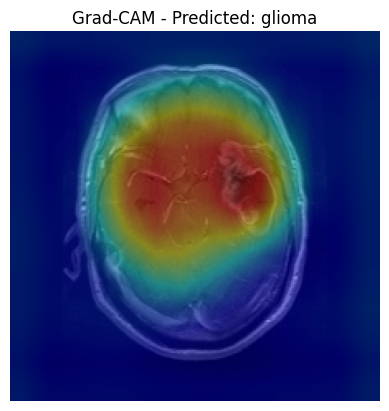

1/1 [==============================] - 0s 78ms/step


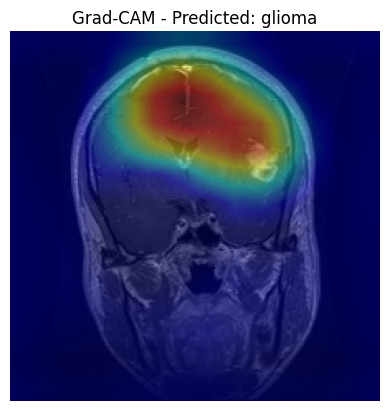


Generating Grad-CAM for class: meningioma

1/1 [==============================] - 0s 74ms/step


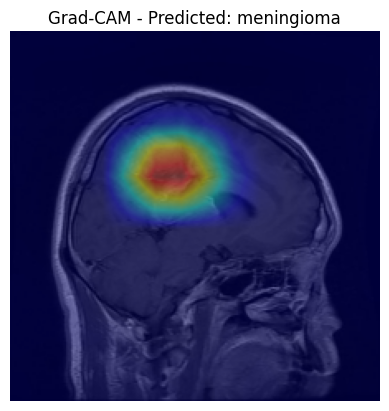

1/1 [==============================] - 0s 75ms/step


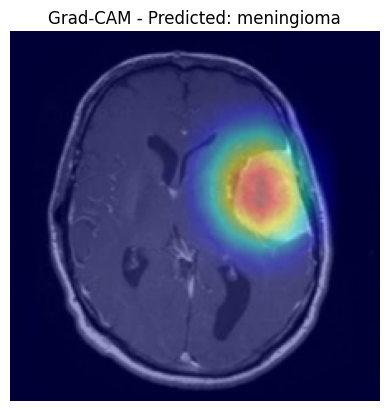

1/1 [==============================] - 0s 74ms/step


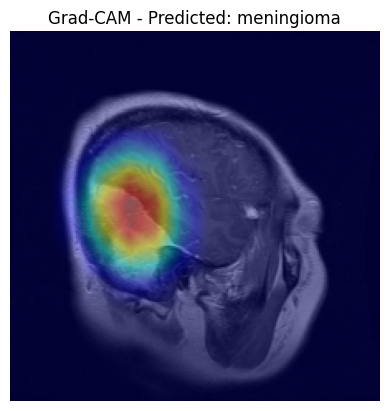


Generating Grad-CAM for class: notumor

1/1 [==============================] - 0s 73ms/step


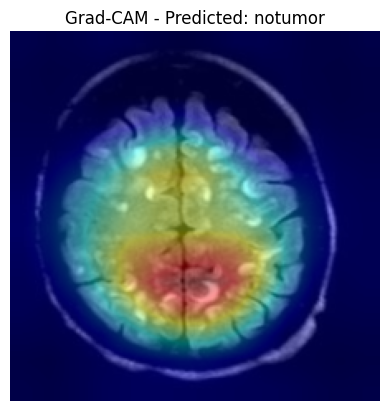

1/1 [==============================] - 0s 76ms/step


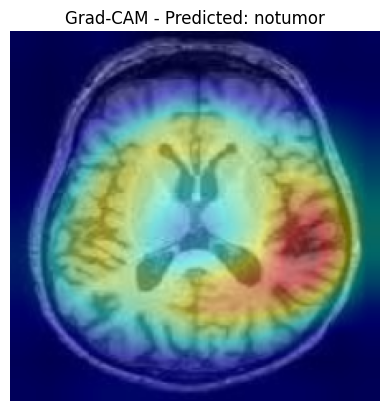

1/1 [==============================] - 0s 75ms/step


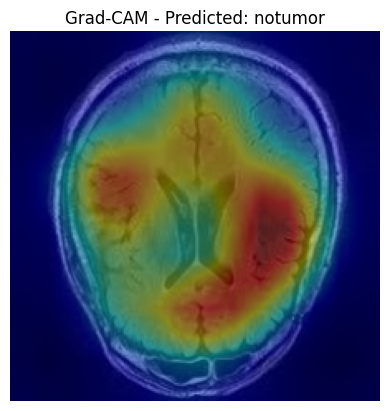


Generating Grad-CAM for class: pituitary

1/1 [==============================] - 0s 74ms/step


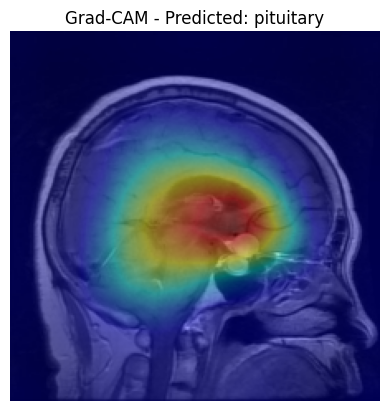

1/1 [==============================] - 0s 73ms/step


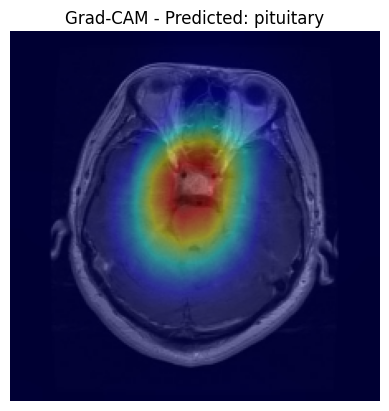

1/1 [==============================] - 0s 73ms/step


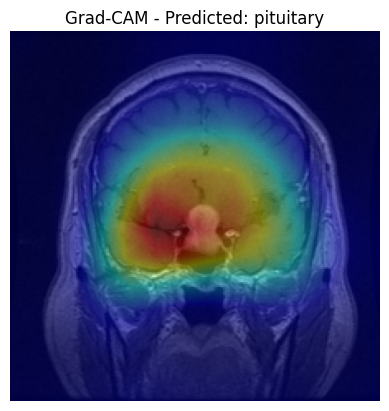

In [25]:
for label, paths in sample_image_paths.items():
    print(f"\nGenerating Grad-CAM for class: {label}\n")
    for img_path in paths:
        visualize_gradcam(img_path, vgg_model, layer_name='block5_conv3', class_labels=class_labels)

In [26]:
# Save the model
vgg_model.save('vgg16_model.h5')

# Load the model
from tensorflow.keras.models import load_model
loaded_model = load_model('vgg16_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(x_train_final)

In [28]:
# Load Pretrained ResNet50 Model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Fine-Tuning: Unfreeze the Last 50 Layers
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Custom Top Layers
x = base_model.output
x = Flatten()(x)
x = Dense(256, kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
x = Dropout(0.2)(x)  # Adjusted Dropout
output = Dense(4, activation='softmax')(x)  # 4 classes: glioma, meningioma, notumor, pituitary

# Define Model
resnet_model = Model(inputs=base_model.input, outputs=output)

# Compile Model
resnet_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

94765736/94765736 [==============================] - 0s 0us/step


In [29]:
# Callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-8),
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ModelCheckpoint('best_resnet50_model.h5', monitor='val_loss', save_best_only=True)
]

In [30]:
# Updated epochs with early stopping
history_resnet = resnet_model.fit(
    datagen.flow(x_train_final, y_train_final, batch_size=32),
    validation_data=(x_val, y_val),
    epochs=30,  # Start with 30 epochs
    callbacks=callbacks
)


Epoch 1/30
50/50 [==============================] - 63s 1s/step - loss: 5.9935 - accuracy: 0.6012 - precision_1: 0.6614 - recall_1: 0.5238 - val_loss: 7.0159 - val_accuracy: 0.2675 - val_precision_1: 0.2675 - val_recall_1: 0.2675 - lr: 1.0000e-05
Epoch 2/30
50/50 [==============================] - 54s 1s/step - loss: 5.6556 - accuracy: 0.6856 - precision_1: 0.7328 - recall_1: 0.6275 - val_loss: 6.1450 - val_accuracy: 0.2675 - val_precision_1: 0.4352 - val_recall_1: 0.2350 - lr: 1.0000e-05
Epoch 3/30
50/50 [==============================] - 53s 1s/step - loss: 5.4477 - accuracy: 0.7031 - precision_1: 0.7430 - recall_1: 0.6431 - val_loss: 5.7046 - val_accuracy: 0.4775 - val_precision_1: 0.8295 - val_recall_1: 0.1825 - lr: 1.0000e-05
Epoch 4/30
50/50 [==============================] - 53s 1s/step - loss: 5.2580 - accuracy: 0.7287 - precision_1: 0.7654 - recall_1: 0.6750 - val_loss: 5.2819 - val_accuracy: 0.6775 - val_precision_1: 0.8224 - val_recall_1: 0.4400 - lr: 1.0000e-05
Epoch 5/30
5

In [31]:
# Evaluate the model
results = resnet_model.evaluate(x_test, y_test_classification)
test_loss, test_accuracy, test_precision, test_recall = results

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")



41/41 [==============================] - 23s 553ms/step - loss: 3.1660 - accuracy: 0.8162 - precision_1: 0.8277 - recall_1: 0.7986
Test Loss: 3.16603422164917
Test Accuracy: 0.816170871257782
Test Precision: 0.8276680111885071
Test Recall: 0.7986270189285278


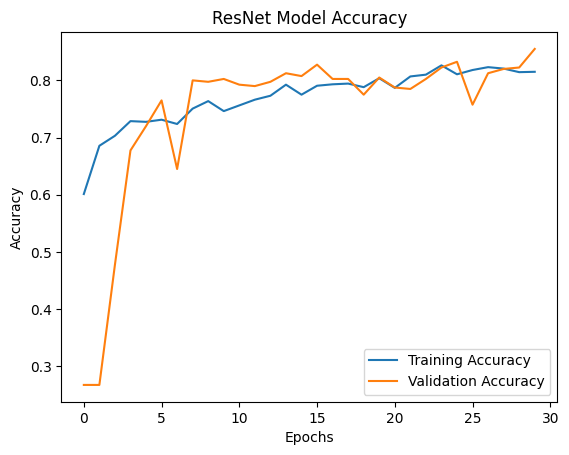

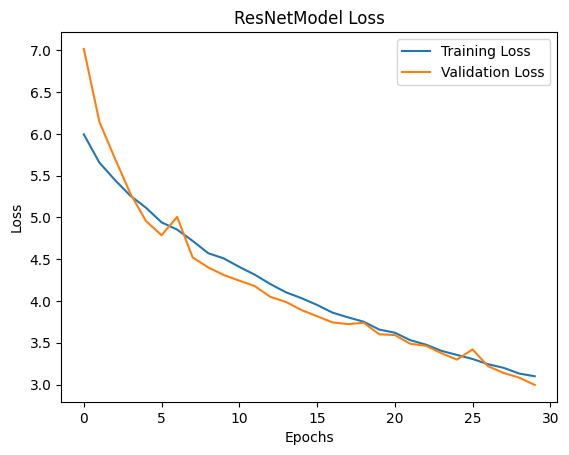

In [32]:
# Plot training and validation accuracy for ResNet50
plt.plot(history_resnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Validation Accuracy')
plt.title("ResNet Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot training and validation loss for ResNet50
plt.plot(history_resnet.history['loss'], label='Training Loss')
plt.plot(history_resnet.history['val_loss'], label='Validation Loss')
plt.title("ResNetModel Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


50/50 [==============================] - 27s 522ms/step


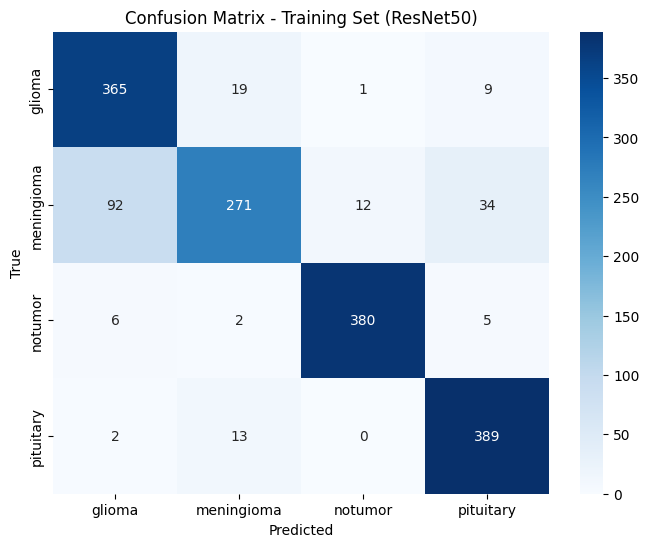

In [33]:
# Get predictions for the training set
y_pred_train_resnet = np.argmax(resnet_model.predict(x_train_final), axis=1)
y_true_train_resnet = np.argmax(y_train_final, axis=1)

# Generate the confusion matrix for ResNet50
cm_train_resnet = confusion_matrix(y_true_train_resnet, y_pred_train_resnet)

# Plot confusion matrix for the training set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train_resnet, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Training Set (ResNet50)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


41/41 [==============================] - 23s 525ms/step

Classification Report - ResNet50:
               precision    recall  f1-score   support

      glioma       0.76      0.83      0.79       300
  meningioma       0.74      0.49      0.59       306
     notumor       0.86      0.95      0.90       405
   pituitary       0.86      0.95      0.90       300

    accuracy                           0.82      1311
   macro avg       0.80      0.81      0.80      1311
weighted avg       0.81      0.82      0.81      1311



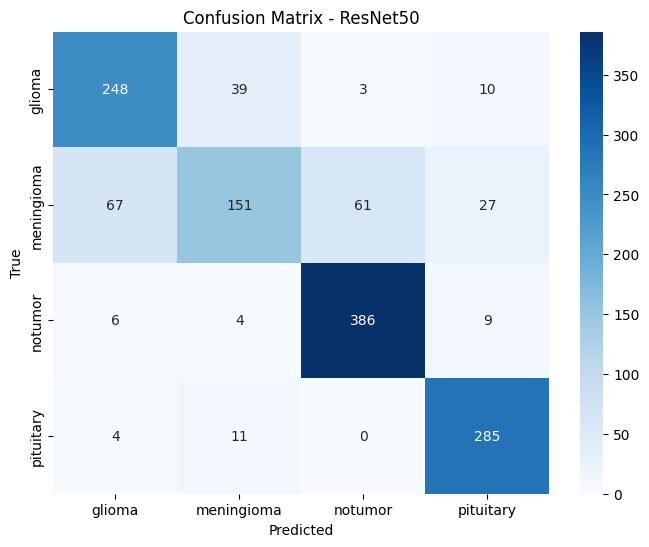

In [34]:
# Predictions for ResNet50
y_pred_resnet = np.argmax(resnet_model.predict(x_test), axis=1)
y_true_resnet = np.argmax(y_test_classification, axis=1)

# Classification report for ResNet50
print("\nClassification Report - ResNet50:\n", classification_report(y_true_resnet, y_pred_resnet, target_names=labels))

# Confusion matrix for ResNet50
cm_resnet = confusion_matrix(y_true_resnet, y_pred_resnet)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - ResNet50")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


41/41 [==============================] - 21s 515ms/step


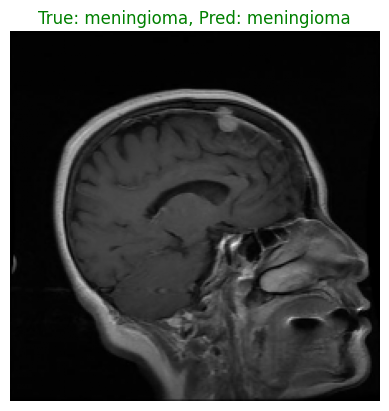

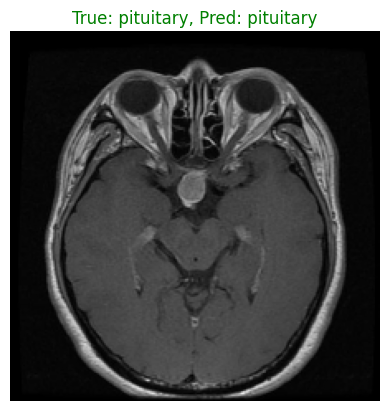

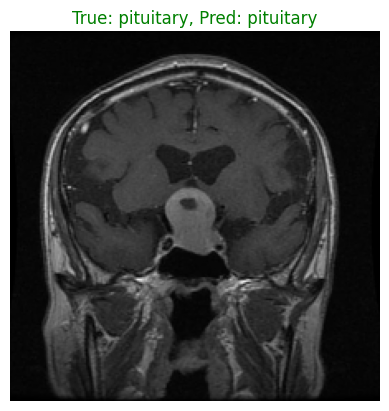

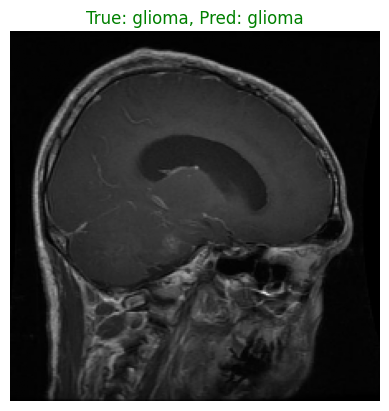

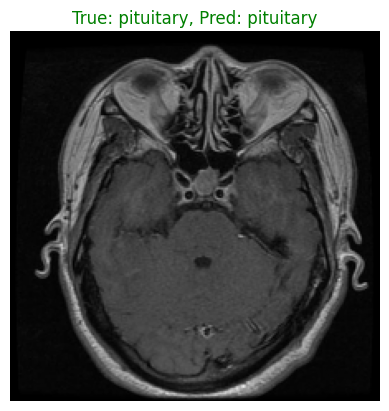

In [35]:
# Get predictions for the test set
resnet_predictions = np.argmax(resnet_model.predict(x_test), axis=1)  # Predictions for x_test

# Display 5 random images with true and predicted labels
for i in range(5):
    idx = random.randint(0, len(x_test) - 1)  # Select a random index
    plt.imshow(x_test[idx])  # Display the image
    true_label = labels[np.argmax(y_test_classification[idx])]  # True label
    predicted_label = labels[resnet_predictions[idx]]  # Predicted label
    color = 'green' if true_label == predicted_label else 'red'  # Correct = green, Incorrect = red
    plt.title(f"True: {true_label}, Pred: {predicted_label}", color=color)
    plt.axis('off')  # Hide axes
    plt.show()  # Display the image


Class: glioma
  /content/drive/MyDrive/project/brain tumor/Testing/glioma/Te-gl_0024.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/glioma/Te-gl_0182.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/glioma/Te-gl_0250.jpg
Class: meningioma
  /content/drive/MyDrive/project/brain tumor/Testing/meningioma/Te-me_0136.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/meningioma/Te-me_0161.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/meningioma/Te-me_0257.jpg
Class: notumor
  /content/drive/MyDrive/project/brain tumor/Testing/notumor/Te-noTr_0006.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/notumor/Te-no_0245.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/notumor/Te-no_0074.jpg
Class: pituitary
  /content/drive/MyDrive/project/brain tumor/Testing/pituitary/Te-pi_0197.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/pituitary/Te-pi_0056.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/pituitary/Te-pi_0105.jpg

Generatin

<ipython-input-36-ff9ce72a5c16>:64: RuntimeWarning: invalid value encountered in divide
  heatmap /= np.max(heatmap)
<ipython-input-36-ff9ce72a5c16>:70: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


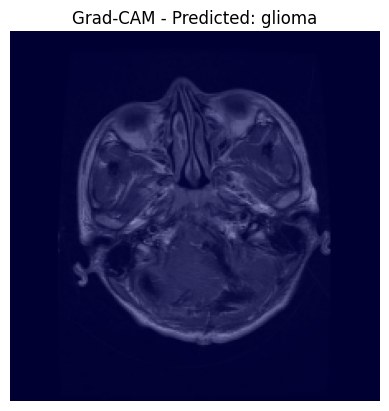

1/1 [==============================] - 0s 96ms/step


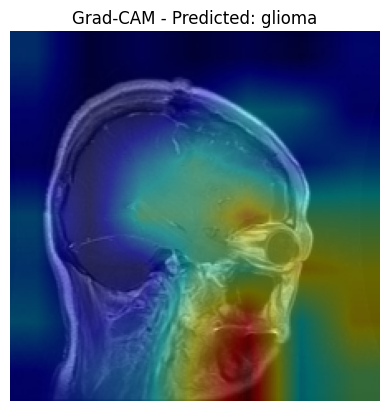

1/1 [==============================] - 0s 102ms/step


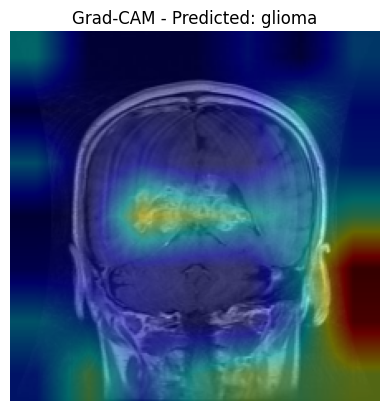


Generating Grad-CAM for class: meningioma

1/1 [==============================] - 0s 96ms/step


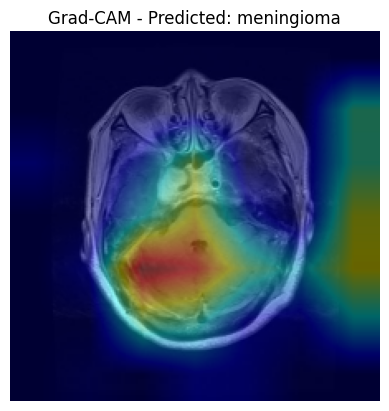

1/1 [==============================] - 0s 97ms/step


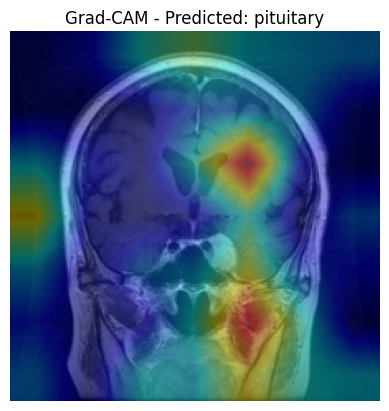

1/1 [==============================] - 0s 97ms/step


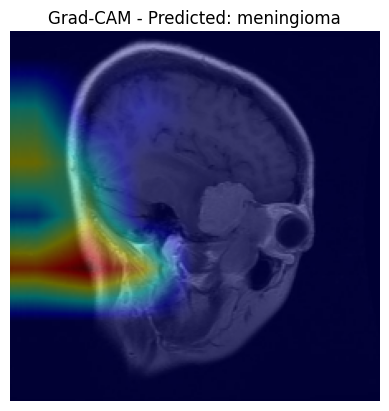


Generating Grad-CAM for class: notumor

1/1 [==============================] - 0s 103ms/step


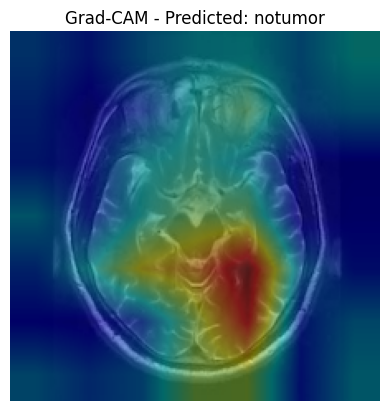

1/1 [==============================] - 0s 97ms/step


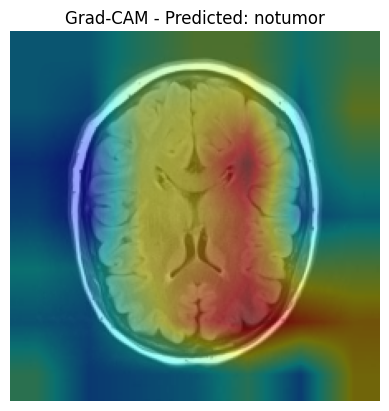

1/1 [==============================] - 0s 95ms/step


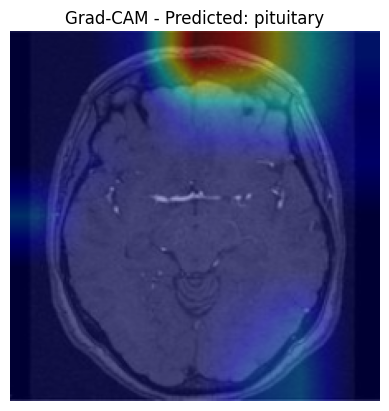


Generating Grad-CAM for class: pituitary

1/1 [==============================] - 0s 100ms/step


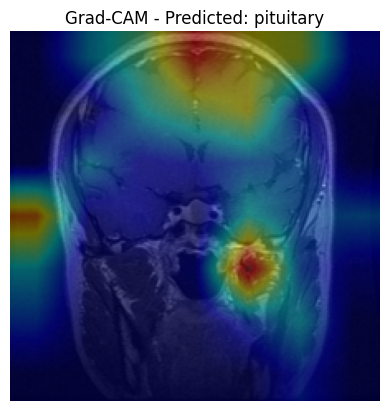

1/1 [==============================] - 0s 97ms/step


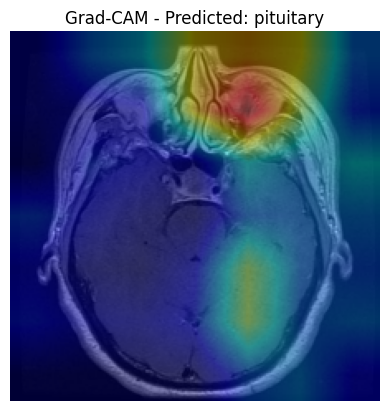

1/1 [==============================] - 0s 97ms/step


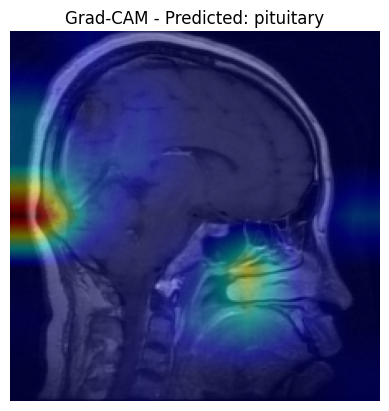

In [36]:
# Define the dataset path and classes
base_path = '/content/drive/MyDrive/project/brain tumor'
class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
data_folders = ['Training', 'Testing']  # Choose whether to use Training or Testing images

# Function to fetch random images from each class
def fetch_images(base_path, data_folder, class_labels, num_samples=3):
    images_by_class = {}
    for label in class_labels:
        folder_path = os.path.join(base_path, data_folder, label)
        all_files = os.listdir(folder_path)
        sampled_files = random.sample(all_files, min(len(all_files), num_samples))  # Randomly sample
        images_by_class[label] = [os.path.join(folder_path, f) for f in sampled_files]
    return images_by_class

# Fetch images dynamically
sample_image_paths = fetch_images(base_path, 'Testing', class_labels)

# Print selected images for verification
for label, paths in sample_image_paths.items():
    print(f"Class: {label}")
    for path in paths:
        print(f"  {path}")


def visualize_gradcam_resnet(img_path, model, layer_name, class_labels):
    """
    Generate and display Grad-CAM heatmaps for an input image for ResNet50.
    """


    # Load and preprocess the image
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize pixel values

    # Create a model that outputs the activations of the target layer
    grad_model = Model(
        inputs=[model.input],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    # Get the class index with the highest predicted probability
    preds = model.predict(img_array)
    pred_class_idx = np.argmax(preds[0])

    # Compute the gradient of the predicted class with respect to the activations
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, pred_class_idx]

    # Compute gradients
    grads = tape.gradient(loss, conv_outputs)
    guided_grads = grads[0]
    conv_outputs = conv_outputs[0]

    # Compute the Grad-CAM heatmap
    weights = np.mean(guided_grads, axis=(0, 1))
    heatmap = np.dot(conv_outputs, weights)

    # Normalize the heatmap between 0 and 1
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    # Resize heatmap to match the image size
    heatmap = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))

    # Convert heatmap to RGB format
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose heatmap onto the original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))  # Resize image to match Grad-CAM heatmap
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    # Display the image
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Grad-CAM - Predicted: {class_labels[pred_class_idx]}")
    plt.axis('off')
    plt.show()

# Specify the last convolutional layer in ResNet50
layer_name = 'conv5_block3_out'  # Adjust based on your ResNet50 architecture

# Generate Grad-CAM for each class
for label, paths in sample_image_paths.items():
    print(f"\nGenerating Grad-CAM for class: {label}\n")
    for img_path in paths:
        visualize_gradcam_resnet(img_path, resnet_model, layer_name, class_labels=class_labels)


In [37]:
# Save the model
resnet_model.save('resnet_model.h5')

# Load the model
from tensorflow.keras.models import load_model
loaded_model = load_model('resnet_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [38]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,  # Reduced for smoother augmentation
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,  # Vertical flips removed (not relevant for medical images)
    fill_mode='nearest'
)
datagen.fit(x_train)

In [39]:
# Define the Model Architecture
def create_custom_cnn(input_shape, num_classes):
    model = Sequential()

    # First Convolutional Block
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second Convolutional Block
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Third Convolutional Block
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Fourth Convolutional Block
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))  # L2 regularization added
    model.add(Dropout(0.5))  # Stronger regularization to avoid overfitting
    model.add(Dense(num_classes, activation='softmax'))  # Final classification layer

    return model

# Define the model
input_shape = (224, 224, 3)  # Input size
num_classes = 4  # Number of tumor classes
custom_cnn = create_custom_cnn(input_shape, num_classes)

# Learning Rate Scheduler
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-4,  # Slightly lower starting LR
    decay_steps=1000,
    decay_rate=0.95,
    staircase=True
)

# Compile the Model
custom_cnn.compile(
    optimizer=Adam(learning_rate=lr_schedule),  # Switched to Adam for better optimization
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

# Display the Model Summary
custom_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_1 (Bat  (None, 224, 224, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_2 (Bat  (None, 112, 112, 64)      256       
 chNormalization)                                                
                                                        

In [40]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),  # Allow more patience
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6),
    ModelCheckpoint('best_custom_cnn.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
]

In [41]:
# Train the Model
history_custom_cnn = custom_cnn.fit(
    datagen.flow(x_train, y_train_classification, batch_size=32),
    validation_data=(x_val, y_val),
    epochs=50,  # Allow up to 50 epochs for better convergence
    callbacks=callbacks
)

Epoch 1/50
63/63 [==============================] - ETA: 0s - loss: 6.6834 - accuracy: 0.5090 - precision: 0.5550 - recall: 0.4290
Epoch 1: val_loss improved from inf to 9.96464, saving model to best_custom_cnn.h5
63/63 [==============================] - 50s 758ms/step - loss: 6.6834 - accuracy: 0.5090 - precision: 0.5550 - recall: 0.4290 - val_loss: 9.9646 - val_accuracy: 0.2650 - val_precision: 0.2650 - val_recall: 0.2650 - lr: 1.0000e-04
Epoch 2/50
63/63 [==============================] - ETA: 0s - loss: 5.7809 - accuracy: 0.5860 - precision: 0.6884 - recall: 0.4375
Epoch 2: val_loss improved from 9.96464 to 9.67697, saving model to best_custom_cnn.h5
63/63 [==============================] - 47s 742ms/step - loss: 5.7809 - accuracy: 0.5860 - precision: 0.6884 - recall: 0.4375 - val_loss: 9.6770 - val_accuracy: 0.2700 - val_precision: 0.2700 - val_recall: 0.2700 - lr: 1.0000e-04
Epoch 3/50
63/63 [==============================] - ETA: 0s - loss: 5.4053 - accuracy: 0.6005 - precision:

In [42]:

test_loss, test_accuracy, test_precision, test_recall = custom_cnn.evaluate(x_test, y_test_classification)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")

41/41 [==============================] - 7s 158ms/step - loss: 0.7250 - accuracy: 0.8459 - precision: 0.8523 - recall: 0.8406
Test Loss: 0.7250164151191711
Test Accuracy: 0.845919132232666
Test Precision: 0.8522815108299255
Test Recall: 0.8405796885490417


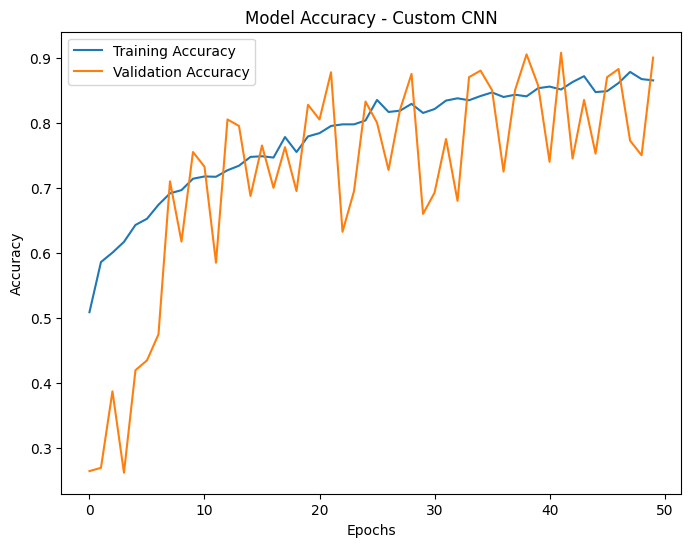

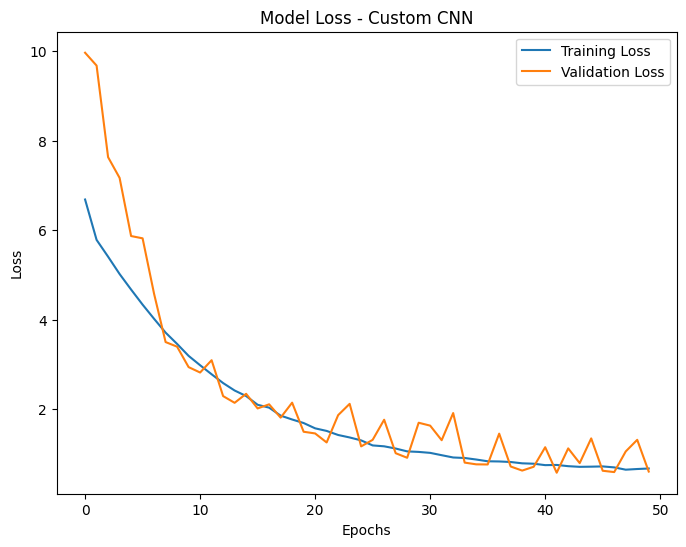

In [43]:
# Plotting Training and Validation Accuracy
plt.figure(figsize=(8, 6))
plt.plot(history_custom_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_custom_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy - Custom CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting Training and Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(history_custom_cnn.history['loss'], label='Training Loss')
plt.plot(history_custom_cnn.history['val_loss'], label='Validation Loss')
plt.title('Model Loss - Custom CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

50/50 [==============================] - 7s 139ms/step


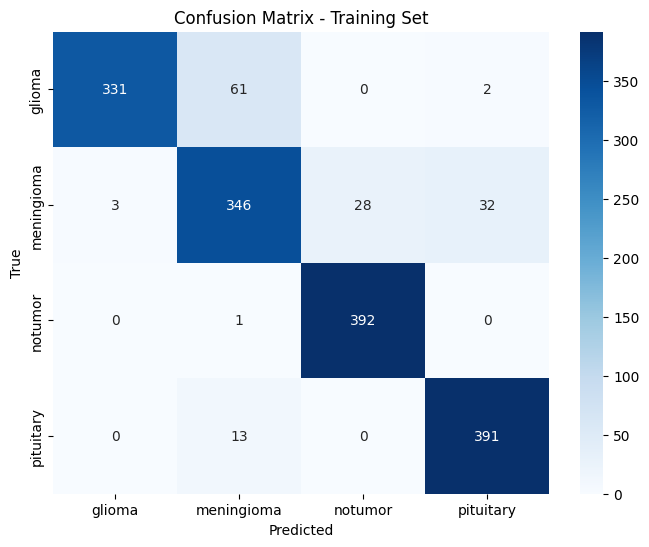

In [44]:
# Get predictions for the training set
y_train_pred = custom_cnn.predict(x_train_final)
y_train_pred_classes = y_train_pred.argmax(axis=1)
y_train_true_classes = y_train_final.argmax(axis=1)

# Generate the confusion matrix
cm_train = confusion_matrix(y_train_true_classes, y_train_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Training Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

41/41 [==============================] - 6s 138ms/step
              precision    recall  f1-score   support

      glioma       0.96      0.72      0.83       300
  meningioma       0.68      0.68      0.68       306
    no tumor       0.84      0.99      0.91       405
   pituitary       0.94      0.95      0.94       300

    accuracy                           0.85      1311
   macro avg       0.85      0.83      0.84      1311
weighted avg       0.85      0.85      0.84      1311



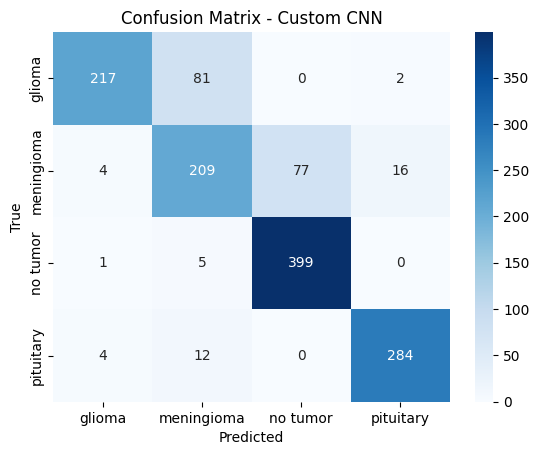

In [45]:

y_pred_test = np.argmax(custom_cnn.predict(x_test), axis=1)
y_true_test = np.argmax(y_test_classification, axis=1)
from sklearn.metrics import classification_report
print(classification_report(y_true_test, y_pred_test, target_names=['glioma', 'meningioma', 'no tumor', 'pituitary']))

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['glioma', 'meningioma', 'no tumor', 'pituitary'],
            yticklabels=['glioma', 'meningioma', 'no tumor', 'pituitary'])
plt.title('Confusion Matrix - Custom CNN')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Class: glioma
  /content/drive/MyDrive/project/brain tumor/Testing/glioma/Te-gl_0207.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/glioma/Te-gl_0067.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/glioma/Te-gl_0274.jpg
Class: meningioma
  /content/drive/MyDrive/project/brain tumor/Testing/meningioma/Te-me_0167.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/meningioma/Te-me_0177.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/meningioma/Te-me_0051.jpg
Class: notumor
  /content/drive/MyDrive/project/brain tumor/Testing/notumor/Te-no_0340.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/notumor/Te-no_0206.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/notumor/Te-no_0218.jpg
Class: pituitary
  /content/drive/MyDrive/project/brain tumor/Testing/pituitary/Te-pi_0257.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/pituitary/Te-pi_0270.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/pituitary/Te-pi_0085.jpg

Generating 

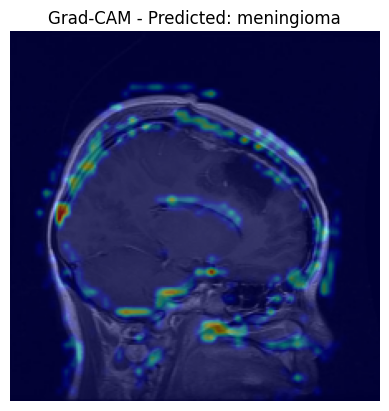

1/1 [==============================] - 0s 45ms/step


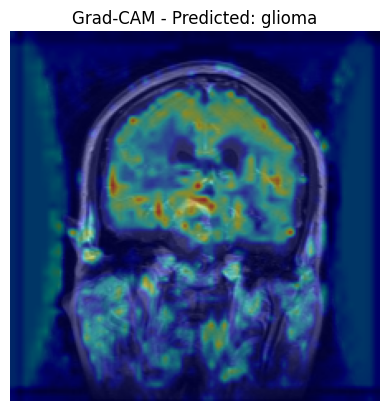

1/1 [==============================] - 0s 41ms/step


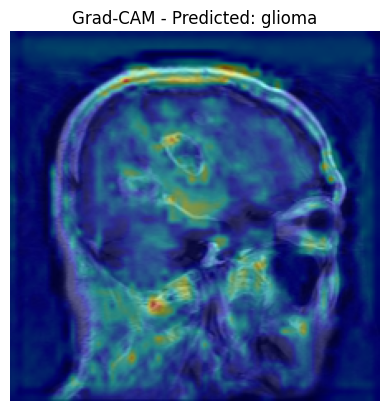


Generating Grad-CAM for class: meningioma

1/1 [==============================] - 0s 41ms/step


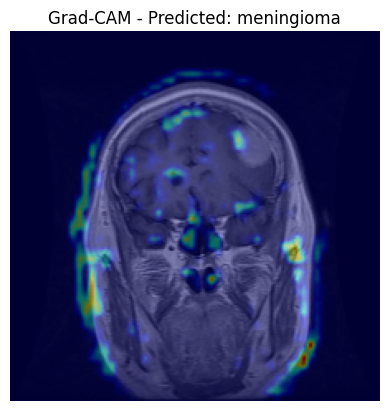

1/1 [==============================] - 0s 41ms/step


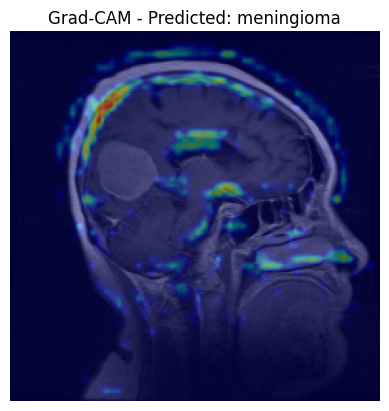

1/1 [==============================] - 0s 41ms/step


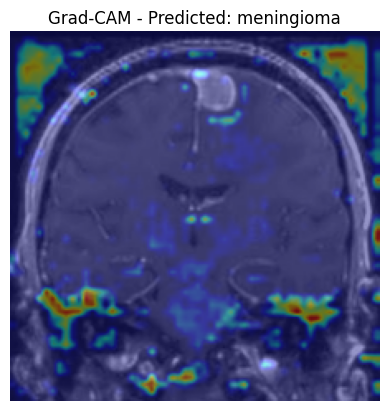


Generating Grad-CAM for class: notumor

1/1 [==============================] - 0s 41ms/step


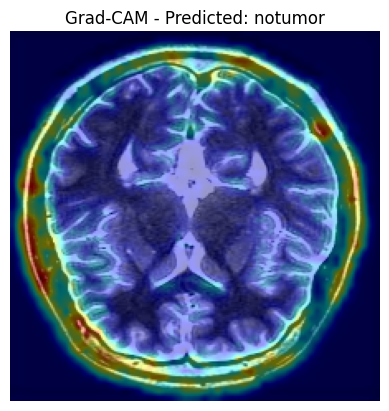

1/1 [==============================] - 0s 42ms/step


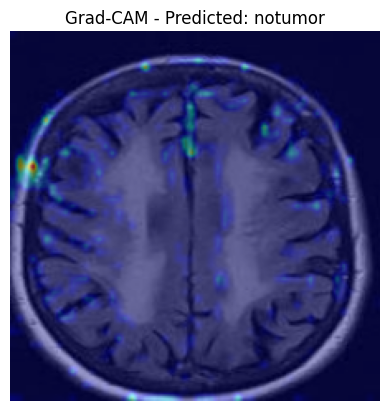

1/1 [==============================] - 0s 41ms/step


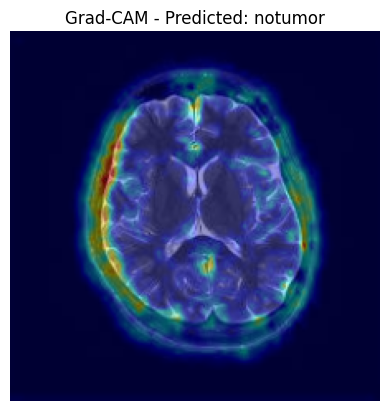


Generating Grad-CAM for class: pituitary

1/1 [==============================] - 0s 41ms/step


<ipython-input-46-9ef65698a942>:62: RuntimeWarning: invalid value encountered in divide
  heatmap /= np.max(heatmap)
<ipython-input-46-9ef65698a942>:68: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


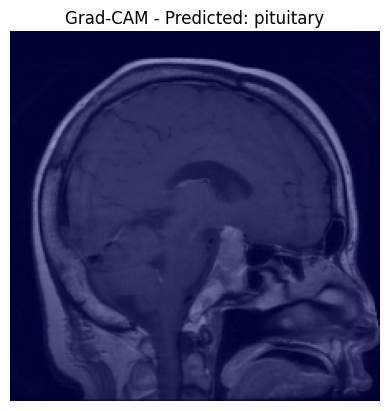

1/1 [==============================] - 0s 42ms/step


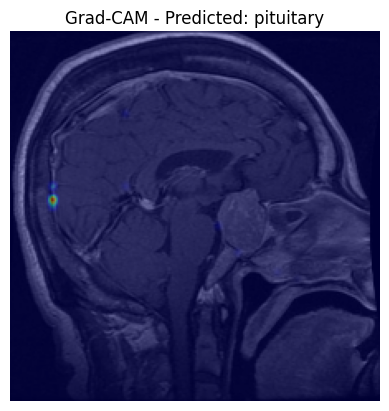

1/1 [==============================] - 0s 49ms/step


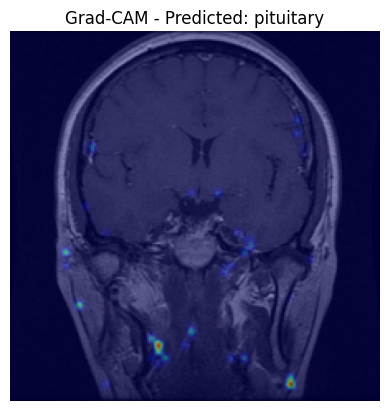

In [46]:
# Define the dataset path and classes
base_path = '/content/drive/MyDrive/project/brain tumor'
class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
data_folders = ['Training', 'Testing']  # Choose whether to use Training or Testing images

# Function to fetch random images from each class
def fetch_images(base_path, data_folder, class_labels, num_samples=3):
    images_by_class = {}
    for label in class_labels:
        folder_path = os.path.join(base_path, data_folder, label)
        all_files = os.listdir(folder_path)
        sampled_files = random.sample(all_files, min(len(all_files), num_samples))  # Randomly sample
        images_by_class[label] = [os.path.join(folder_path, f) for f in sampled_files]
    return images_by_class

# Fetch images dynamically
sample_image_paths = fetch_images(base_path, 'Testing', class_labels)

# Print selected images for verification
for label, paths in sample_image_paths.items():
    print(f"Class: {label}")
    for path in paths:
        print(f"  {path}")

# Grad-CAM function for Custom CNN
def visualize_gradcam_custom(img_path, model, layer_name, class_labels):
    """
    Generate and display Grad-CAM heatmaps for an input image for Custom CNN.
    """
    # Load and preprocess the image
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize pixel values

    # Create a model that outputs the activations of the target layer
    grad_model = Model(
        inputs=[model.input],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    # Get the class index with the highest predicted probability
    preds = model.predict(img_array)
    pred_class_idx = np.argmax(preds[0])

    # Compute the gradient of the predicted class with respect to the activations
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, pred_class_idx]

    # Compute gradients
    grads = tape.gradient(loss, conv_outputs)
    guided_grads = grads[0]
    conv_outputs = conv_outputs[0]

    # Compute the Grad-CAM heatmap
    weights = np.mean(guided_grads, axis=(0, 1))
    heatmap = np.dot(conv_outputs, weights)

    # Normalize the heatmap between 0 and 1
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    # Resize heatmap to match the image size
    heatmap = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))

    # Convert heatmap to RGB format
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose heatmap onto the original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))  # Resize image to match Grad-CAM heatmap
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    # Display the image
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Grad-CAM - Predicted: {class_labels[pred_class_idx]}")
    plt.axis('off')
    plt.show()

# Specify the last convolutional layer in your custom CNN
# Use model.summary() to identify the correct layer
layer_name = 'conv2d_2'  # Adjust this to the last convolutional layer in your custom CNN

# Generate Grad-CAM for each class
for label, paths in sample_image_paths.items():
    print(f"\nGenerating Grad-CAM for class: {label}\n")
    for img_path in paths:
        visualize_gradcam_custom(img_path, custom_cnn, layer_name, class_labels=class_labels)


In [47]:
# Save the model
custom_cnn.save('custom_cnn_model.h5')

# Load the model
from tensorflow.keras.models import load_model
loaded_model = load_model('custom_cnn_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 6s 146ms/step
              precision    recall  f1-score   support

      glioma       0.98      0.93      0.96       300
  meningioma       0.91      0.83      0.86       306
     notumor       0.91      0.99      0.95       405
   pituitary       0.97      0.99      0.98       300

    accuracy                           0.94      1311
   macro avg       0.94      0.93      0.94      1311
weighted avg       0.94      0.94      0.94      1311



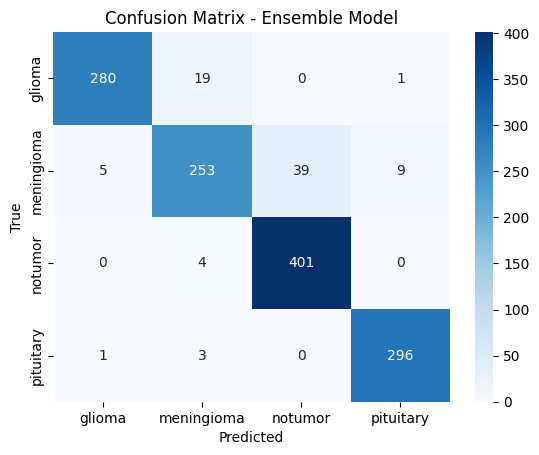

In [48]:
# Get predicted probabilities for each model
vgg_probs = vgg_model.predict(x_test)
resnet_probs = resnet_model.predict(x_test)
custom_probs = custom_cnn.predict(x_test)

# Average the probabilities
ensemble_probs = (vgg_probs + resnet_probs + custom_probs) / 3

# Get the final predictions
ensemble_preds = np.argmax(ensemble_probs, axis=1)

# Evaluate performance
print(classification_report(np.argmax(y_test_classification, axis=1), ensemble_preds, target_names=labels))
cm = confusion_matrix(np.argmax(y_test_classification, axis=1), ensemble_preds)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Ensemble Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [49]:


# Assuming `ensemble_preds` are your ensemble model's predictions
y_true = np.argmax(y_test_classification, axis=1)  # True labels (one-hot encoded)

# Calculate metrics
accuracy = accuracy_score(y_true, ensemble_preds)
precision = precision_score(y_true, ensemble_preds, average='weighted')
recall = recall_score(y_true, ensemble_preds, average='weighted')
f1 = f1_score(y_true, ensemble_preds, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")


Accuracy: 0.9382151029748284
Precision: 0.9385877313750428
Recall: 0.9382151029748284
F1-Score: 0.9373197424463895


41/41 [==============================] - 7s 161ms/step
                        Model  Accuracy  Precision    Recall  F1-Score
0                       VGG16  0.963387   0.963360  0.963387  0.963301
1                    ResNet50  0.816171   0.808563  0.816171  0.805193
2                  Custom CNN  0.845919   0.852766  0.845919  0.843698
3  Ensemble (Majority Voting)  0.915332   0.915099  0.915332  0.914015


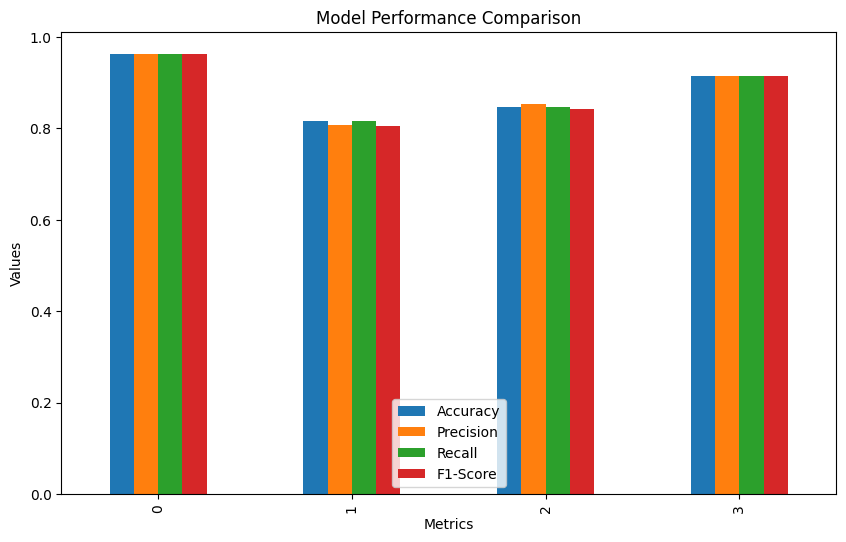

In [50]:


# Get predictions for each individual model
vgg_preds = np.argmax(vgg_model.predict(x_test), axis=1)
resnet_preds = np.argmax(resnet_model.predict(x_test), axis=1)
custom_preds = np.argmax(custom_cnn.predict(x_test), axis=1)

# True labels
y_true = np.argmax(y_test_classification, axis=1)

# Ensemble model predictions (majority voting)
ensemble_preds = []
for i in range(len(vgg_preds)):
    preds = [vgg_preds[i], resnet_preds[i], custom_preds[i]]
    ensemble_preds.append(max(set(preds), key=preds.count))

# Evaluation function
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return {"Model": model_name, "Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1-Score": f1}

# Evaluate all models
results = []
results.append(evaluate_model(y_true, vgg_preds, "VGG16"))
results.append(evaluate_model(y_true, resnet_preds, "ResNet50"))
results.append(evaluate_model(y_true, custom_preds, "Custom CNN"))
results.append(evaluate_model(y_true, ensemble_preds, "Ensemble (Majority Voting)"))

# Convert results to DataFrame for comparison
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

# Alternatively, if you want to visualize it better
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'results_df' is a DataFrame
results_df.plot(kind='bar', figsize=(10, 6))
plt.title("Model Performance Comparison")
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.legend(loc="best")
plt.show()





In [55]:
from tensorflow.keras.models import save_model

# Save the model
save_model(custom_cnn, 'ensemble_model.h5')


<ipython-input-55-285e6a6ca9b5>:4: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(custom_cnn, 'ensemble_model.h5')  # Example: Save Custom CNN as ensemble
